In [1]:
import os 
os.listdir('/kaggle/input') 

embeddings_path = "/kaggle/input/embeddings"
print(os.listdir(embeddings_path))

['speeches_with_embeddings.csv', 'speeches_embeddings_sentiment.csv', 'news_embeddings_sentiment.csv', 'news_with_embeddings.csv']


In [2]:
import pandas as pd

speeches_embeddings = pd.read_csv(f"{embeddings_path}/speeches_with_embeddings.csv")
news_embeddings = pd.read_csv(f"{embeddings_path}/news_with_embeddings.csv")

# Display first few rows
print("News Data:")
print(news_embeddings.head())

print("\nSpeeches Data:")
print(speeches_embeddings.head())

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [ ]:
import pandas as pd
import numpy as np
import torch
import re

# Convert date columns to datetime
news_embeddings['Date'] = pd.to_datetime(news_embeddings['Date'])
speeches_embeddings['date'] = pd.to_datetime(speeches_embeddings['date'])

# Sort both dataframes by date
news_embeddings = news_embeddings.sort_values(by='Date').reset_index(drop=True)
speeches_embeddings = speeches_embeddings.sort_values(by='date').reset_index(drop=True)

# Fix duplicate news indices
duplicate_mask = news_embeddings.duplicated(subset=['Index'], keep=False)
news_embeddings.loc[duplicate_mask, 'Index'] = (
    news_embeddings.loc[duplicate_mask].groupby('Index').cumcount().astype(str) + "_" +
    news_embeddings.loc[duplicate_mask, 'Index']
)

# Generate chunk IDs (Including Date in speech_index)
speeches_embeddings_full = speeches_embeddings.copy()
news_embeddings_full = news_embeddings.copy()

# Ensure 'date' is in string format
speeches_embeddings_full['date_str'] = speeches_embeddings_full['date'].dt.strftime('%Y-%m-%d')

# Generate speech chunk IDs with date
speeches_embeddings_full['chunk_id'] = (
    "speech_" + speeches_embeddings_full['date_str'] + "_" +
    speeches_embeddings_full['speech_id'].astype(str) + "_chunk_" +
    speeches_embeddings_full.groupby('speech_id').cumcount().astype(str)
)

# Generate news chunk IDs
news_embeddings_full['chunk_id'] = news_embeddings_full.groupby('Index').cumcount()
news_embeddings_full['chunk_id'] = (
    "news_" + news_embeddings_full['Index'].astype(str) + "_chunk_" +
    news_embeddings_full['chunk_id'].astype(str)
)

# Track chunk IDs for alignment
speech_tracking_df_full = speeches_embeddings_full[['speech_id', 'chunk_id', 'date']].reset_index(drop=True)
news_tracking_df_full = news_embeddings_full[['Index', 'chunk_id', 'Date']].reset_index(drop=True)

# Sort and format dates
speech_tracking_df_full = speech_tracking_df_full.sort_values(by=['date', 'speech_id']).reset_index(drop=True)
news_tracking_df_full = news_tracking_df_full.sort_values(by=['Date', 'Index']).reset_index(drop=True)

speech_tracking_df_full['date'] = speech_tracking_df_full['date'].dt.strftime('%Y-%m-%d')
news_tracking_df_full['Date'] = news_tracking_df_full['Date'].dt.strftime('%Y-%m-%d')

# **Check the full date range before filtering**
print(f"🔍 Full News Date Range: {news_embeddings['Date'].min()} to {news_embeddings['Date'].max()}")
print(f"🔍 Full Speeches Date Range: {speeches_embeddings['date'].min()} to {speeches_embeddings['date'].max()}")

# Find common dates and filter
common_dates_full = set(speech_tracking_df_full['date']).intersection(set(news_tracking_df_full['Date']))

# Check if common dates are too limited
if len(common_dates_full) > 0:
    print(f"✅ Common Date Range: {min(common_dates_full)} to {max(common_dates_full)}")
else:
    print("⚠️ Warning: No common dates found!")

speech_tracking_df_full = speech_tracking_df_full[speech_tracking_df_full['date'].isin(common_dates_full)].reset_index(drop=True)
news_tracking_df_full = news_tracking_df_full[news_tracking_df_full['Date'].isin(common_dates_full)].reset_index(drop=True)
# Inspect the first few rows of speech and news tracking dataframes
print("Last few rows of Speech Tracking DataFrame:")
print(speech_tracking_df_full.tail())

print("\nLast few rows of News Tracking DataFrame:")
print(news_tracking_df_full.tail())
# Check the lengths of the filtered tracking dataframes
print(f"Length of filtered speech_tracking_df_full: {len(speech_tracking_df_full)}")
print(f"Length of filtered news_tracking_df_full: {len(news_tracking_df_full)}")
# Check the first and last dates in the filtered dataframes
print("First date in speech_tracking_df_full:", speech_tracking_df_full['date'].min())
print("Last date in speech_tracking_df_full:", speech_tracking_df_full['date'].max())

print("First date in news_tracking_df_full:", news_tracking_df_full['Date'].min())
print("Last date in news_tracking_df_full:", news_tracking_df_full['Date'].max())


In [ ]:
# Step 1: Generate chunk IDs for both embeddings and tracking dataframes
# This assumes that you already have `speeches_embeddings` and `news_embeddings` with embeddings generated for each row.

# Create chunk IDs for speeches_embeddings
speeches_embeddings['chunk_id'] = speeches_embeddings.groupby('speech_id').cumcount()

# Create chunk IDs for news_embeddings (assuming each article has one chunk)
news_embeddings['chunk_id'] = news_embeddings.groupby('Index').cumcount()

# Step 2: Generate tracking dataframes with proper chunking
speech_tracking_df_full = speeches_embeddings[['speech_id', 'chunk_id', 'date']].reset_index(drop=True)
news_tracking_df_full = news_embeddings[['Index', 'chunk_id', 'Date']].reset_index(drop=True)

# Step 3: Check and print the shape of tracking dataframes
print(f"Shape of Speech Tracking DataFrame: {speech_tracking_df_full.shape}")
print(f"Shape of News Tracking DataFrame: {news_tracking_df_full.shape}")

# Step 4: Ensure the chunk_ids align between embeddings and tracking dataframes
assert len(speech_tracking_df_full) == len(speeches_embeddings), "Speech tracking dataframe length mismatch!"
assert len(news_tracking_df_full) == len(news_embeddings), "News tracking dataframe length mismatch!"

# Step 5: Check and print the shape of embeddings tensors
print(f"Shape of Speech Embeddings Tensor: {speeches_embeddings.shape}")
print(f"Shape of News Embeddings Tensor: {news_embeddings.shape}")

# Step 6: Ensure the number of rows match between expanded dataframe and embeddings tensor
assert speeches_embeddings.shape[0] == speech_tracking_df_full.shape[0], "Mismatch in rows between speech embeddings and tracking dataframe!"
assert news_embeddings.shape[0] == news_tracking_df_full.shape[0], "Mismatch in rows between news embeddings and tracking dataframe!"

# Optional: Print some sample rows for validation
print(f"Sample Speech Tracking Data: {speech_tracking_df_full.head()}")
print(f"Sample News Tracking Data: {news_tracking_df_full.head()}")


In [ ]:
import pandas as pd
import numpy as np
import torch

def process_embeddings_column(df, column_name):
    """
    Processes embeddings from a DataFrame column. This function:
    - Converts string representations of arrays into NumPy arrays.
    - Removes invalid embeddings.
    - Converts the final list into a PyTorch tensor.

    Args:
    - df (pd.DataFrame): DataFrame containing the embeddings.
    - column_name (str): Name of the column with embeddings.

    Returns:
    - torch.Tensor: Processed tensor with valid embeddings.
    """
    embeddings_list = []
    
    for i, row in df[column_name].items():
        try:
            # Convert string to NumPy array safely
            if isinstance(row, str):
                row = np.fromstring(row.strip("[]"), sep=" ", dtype=np.float32)
            elif isinstance(row, list):
                row = np.array(row, dtype=np.float32)

            # Ensure it's a valid array
            if row.ndim == 1 and row.size > 0:
                embeddings_list.append(row)
        except Exception as e:
            print(f"Skipping row {i} due to error: {e}")

    # Ensure all embeddings have the same shape
    if len(embeddings_list) == 0:
        raise ValueError("No valid embeddings found.")

    try:
        embeddings_matrix = np.vstack(embeddings_list)
    except ValueError:
        raise ValueError("Embeddings have inconsistent sizes.")

    return torch.tensor(embeddings_matrix, dtype=torch.float32)

# Process embeddings
news_embeddings_tensor = process_embeddings_column(news_embeddings, 'news_embeddings')
speeches_embeddings_tensor = process_embeddings_column(speeches_embeddings, 'speech_embeddings')

# Check tensor shapes
print(f"News embeddings shape: {news_embeddings_tensor.shape}")
print(f"Speeches embeddings shape: {speeches_embeddings_tensor.shape}")


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns

def compute_cosine_similarity(news_tensor, speeches_tensor):
    """
    Computes cosine similarity between each news embedding and each speech embedding.

    Args:
    - news_tensor (torch.Tensor): News embeddings of shape (N, D)
    - speeches_tensor (torch.Tensor): Speech embeddings of shape (M, D)

    Returns:
    - pd.DataFrame: DataFrame containing cosine similarity scores.
    """
    # Normalize embeddings
    news_tensor = F.normalize(news_tensor, p=2, dim=1)
    speeches_tensor = F.normalize(speeches_tensor, p=2, dim=1)
    
    # Compute cosine similarity
    similarity_matrix = torch.matmul(speeches_tensor, news_tensor.T)  # (M, N)
    
    # Flatten similarity matrix and convert to DataFrame
    similarity_values = similarity_matrix.numpy().flatten()
    
    return similarity_values

# Compute cosine similarity
cosine_similarities = compute_cosine_similarity(news_embeddings_tensor, speeches_embeddings_tensor)

# Merge cosine similarity with speech tracking data
speech_tracking_df_full["cosine_similarity"] = cosine_similarities

# Aggregate statistics per speech
speech_stats = speech_tracking_df_full.groupby(["speech_id", "date"])["cosine_similarity"].agg(
    mean_sim="mean",
    std_sim="std",
    min_sim="min",
    max_sim="max"
).reset_index()

# Plot function
def plot_cosine_similarity(df, date_col, mean_col, std_col, min_col, max_col):
    """
    Plots cosine similarity trends over time.

    Args:
    - df (pd.DataFrame): DataFrame with computed similarity statistics.
    - date_col (str): Column with speech dates.
    - mean_col (str): Column with mean similarity.
    - std_col (str): Column with std deviation.
    - min_col (str): Column with min similarity.
    - max_col (str): Column with max similarity.
    """
    plt.figure(figsize=(12, 6))
    
    # Line for mean similarity
    sns.lineplot(data=df, x=date_col, y=mean_col, label="Average Cosine Similarity", color="blue")
    
    # Shaded area for ±1 standard deviation
    plt.fill_between(df[date_col], df[mean_col] - df[std_col], df[mean_col] + df[std_col], 
                     alpha=0.2, color="blue", label="±1 Std Dev")

    # Min & Max similarity
    sns.lineplot(data=df, x=date_col, y=min_col, label="Min Cosine Similarity", color="red", linestyle="dashed")
    sns.lineplot(data=df, x=date_col, y=max_col, label="Max Cosine Similarity", color="green", linestyle="dashed")

    # Formatting
    plt.xlabel("Date")
    plt.ylabel("Cosine Similarity")
    plt.title("Cosine Similarity Trends per Speech Over Time")
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    
    plt.show()

# Run the plot
plot_cosine_similarity(
    df=speech_stats, 
    date_col="date", 
    mean_col="mean_sim", 
    std_col="std_sim", 
    min_col="min_sim", 
    max_col="max_sim"
)


### Since we're running out of memory, we'll do it by years 
So 2020, then 2021, 2022, 2023 and 2024 We can then save everything 

In [3]:
import os 
os.listdir('/kaggle/input') 

embeddings_path = "/kaggle/input/embeddings"
print(os.listdir(embeddings_path))

['speeches_with_embeddings.csv', 'speeches_embeddings_sentiment.csv', 'news_embeddings_sentiment.csv', 'news_with_embeddings.csv']


In [4]:
import pandas as pd 

speeches_embeddings = pd.read_csv(f"{embeddings_path}/speeches_with_embeddings.csv")
news_embeddings = pd.read_csv(f"{embeddings_path}/news_with_embeddings.csv")

# Display first few rows
print("News Data:")
print(news_embeddings.head())

print("\nSpeeches Data:")
print(speeches_embeddings.head())

News Data:
          Index                                               Link  \
0  1_01_12_2018  https://www.bbc.com/mundo/noticias-america-lat...   
1  2_01_12_2018  https://politica.expansion.mx/presidencia/2018...   
2  3_01_12_2018  https://oem.com.mx/elsoldemexico/mexico/en-don...   
3  4_01_12_2018  https://politica.expansion.mx/presidencia/2018...   
4  5_01_12_2018  https://www.eleconomista.com.mx/politica/Nicol...   

                                              Domain  \
0  BBC\nToma de protesta de AMLO: las 5 tradicion...   
1  Expansión Política\nAMLO rinde protesta y prom...   
2  El Sol de México\n¿Hay Ley Seca este 1 de dici...   
3  Expansión Política\nAMLO es un "líder persiste...   
4  El Economista\nNicolás Maduro llega a Palacio ...   

                                               Title        Date  \
0  Toma de protesta de AMLO: las 5 tradiciones qu...  2018-12-01   
1        AMLO rinde protesta y promete no reelegirse  2018-12-01   
2  ¿Hay Ley Seca este 1 de 

In [28]:
import pandas as pd
import numpy as np
import torch
import re

# Convert date columns to datetime
news_embeddings['Date'] = pd.to_datetime(news_embeddings['Date'])
speeches_embeddings['date'] = pd.to_datetime(speeches_embeddings['date'])

# Filter data for the year 2020
news_embeddings_2020 = news_embeddings[(news_embeddings['Date'].dt.year == 2020)].copy()
speeches_embeddings_2020 = speeches_embeddings[(speeches_embeddings['date'].dt.year == 2020)].copy()

# Sort both dataframes by date
news_embeddings_2020 = news_embeddings_2020.sort_values(by='Date').reset_index(drop=True)
speeches_embeddings_2020 = speeches_embeddings_2020.sort_values(by='date').reset_index(drop=True)

# **Ensure all dates in news are covered in speeches**
# Remove the block where missing_speech_df is created and concatenated.
# Keep only:
# Speech tracking
speech_tracking = speeches_2020[['speech_id', 'date']].reset_index(drop=True)
speech_tracking['chunk_id'] = (
    "speech_" + speech_tracking['date'].dt.strftime('%Y-%m-%d') + "_" +
    speech_tracking['speech_id'].astype(str) + "_chunk_" +
    speech_tracking.groupby('speech_id').cumcount().astype(str)
)

# News tracking
news_tracking = news_2020[['Index', 'Date']].reset_index(drop=True)
news_tracking['chunk_id'] = (
    "news_" + news_tracking['Index'].astype(str) + "_chunk_" +
    news_tracking.groupby('Index').cumcount().astype(str)
)


# Reprocess embeddings and similarities without zero-padded dates.

# Sort again after adding missing dates
speeches_embeddings_2020 = speeches_embeddings_2020.sort_values(by='date').reset_index(drop=True)

# Fix duplicate news indices
duplicate_mask = news_embeddings_2020.duplicated(subset=['Index'], keep=False)
news_embeddings_2020.loc[duplicate_mask, 'Index'] = (
    news_embeddings_2020.loc[duplicate_mask].groupby('Index').cumcount().astype(str) + "_" +
    news_embeddings_2020.loc[duplicate_mask, 'Index']
)

# Generate chunk IDs (Including Date in speech_index)
speeches_embeddings_full_2020 = speeches_embeddings_2020.copy()
news_embeddings_full_2020 = news_embeddings_2020.copy()

# Ensure 'date' is in string format
speeches_embeddings_full_2020['date_str'] = speeches_embeddings_full_2020['date'].dt.strftime('%Y-%m-%d')

# Generate speech chunk IDs with date
speeches_embeddings_full_2020['chunk_id'] = (
    "speech_" + speeches_embeddings_full_2020['date_str'] + "_" +
    speeches_embeddings_full_2020['speech_id'].astype(str) + "_chunk_" +
    speeches_embeddings_full_2020.groupby('speech_id').cumcount().astype(str)
)

# Generate news chunk IDs
news_embeddings_full_2020['chunk_id'] = news_embeddings_full_2020.groupby('Index').cumcount()
news_embeddings_full_2020['chunk_id'] = (
    "news_" + news_embeddings_full_2020['Index'].astype(str) + "_chunk_" +
    news_embeddings_full_2020['chunk_id'].astype(str)
)

# Track chunk IDs for alignment
speech_tracking_df_full_2020 = speeches_embeddings_full_2020[['speech_id', 'chunk_id', 'date']].reset_index(drop=True)
news_tracking_df_full_2020 = news_embeddings_full_2020[['Index', 'chunk_id', 'Date']].reset_index(drop=True)

# Sort and format dates
speech_tracking_df_full_2020 = speech_tracking_df_full_2020.sort_values(by=['date', 'speech_id']).reset_index(drop=True)
news_tracking_df_full_2020 = news_tracking_df_full_2020.sort_values(by=['Date', 'Index']).reset_index(drop=True)

speech_tracking_df_full_2020['date'] = speech_tracking_df_full_2020['date'].dt.strftime('%Y-%m-%d')
news_tracking_df_full_2020['Date'] = news_tracking_df_full_2020['Date'].dt.strftime('%Y-%m-%d')

# **Check the full date range before filtering**
print(f"🔍 Full News Date Range (2020): {news_embeddings_2020['Date'].min()} to {news_embeddings_2020['Date'].max()}")
print(f"🔍 Full Speeches Date Range (2020): {speeches_embeddings_2020['date'].min()} to {speeches_embeddings_2020['date'].max()}")

# Find common dates and filter
common_dates_2020 = set(speech_tracking_df_full_2020['date']).intersection(set(news_tracking_df_full_2020['Date']))

# Check if common dates are too limited
if len(common_dates_2020) > 0:
    print(f"✅ Common Date Range (2020): {min(common_dates_2020)} to {max(common_dates_2020)}")
else:
    print("⚠️ Warning: No common dates found!")

speech_tracking_df_full_2020 = speech_tracking_df_full_2020[speech_tracking_df_full_2020['date'].isin(common_dates_2020)].reset_index(drop=True)
news_tracking_df_full_2020 = news_tracking_df_full_2020[news_tracking_df_full_2020['Date'].isin(common_dates_2020)].reset_index(drop=True)


# Inspect the first few rows of speech and news tracking dataframes
print("Last few rows of Speech Tracking DataFrame (2020):")
print(speech_tracking_df_full_2020.tail())

print("\nLast few rows of News Tracking DataFrame (2020):")
print(news_tracking_df_full_2020.tail())

# Check the lengths of the filtered tracking dataframes
print(f"Length of filtered speech_tracking_df_full_2020: {len(speech_tracking_df_full_2020)}")
print(f"Length of filtered news_tracking_df_full_2020: {len(news_tracking_df_full_2020)}")

# Check the first and last dates in the filtered dataframes
print("First date in speech_tracking_df_full_2020:", speech_tracking_df_full_2020['date'].min())
print("Last date in speech_tracking_df_full_2020:", speech_tracking_df_full_2020['date'].max())

print("First date in news_tracking_df_full_2020:", news_tracking_df_full_2020['Date'].min())
print("Last date in news_tracking_df_full_2020:", news_tracking_df_full_2020['Date'].max())


🔍 Full News Date Range (2020): 2020-01-02 00:00:00 to 2020-12-31 00:00:00
🔍 Full Speeches Date Range (2020): 2020-01-02 00:00:00 to 2020-12-31 00:00:00
✅ Common Date Range (2020): 2020-01-02 to 2020-12-31
Last few rows of Speech Tracking DataFrame (2020):
       speech_id                         chunk_id        date
29021        978  speech_2020-12-31_978_chunk_108  2020-12-31
29022        978  speech_2020-12-31_978_chunk_109  2020-12-31
29023        978  speech_2020-12-31_978_chunk_110  2020-12-31
29024        978  speech_2020-12-31_978_chunk_111  2020-12-31
29025        978  speech_2020-12-31_978_chunk_112  2020-12-31

Last few rows of News Tracking DataFrame (2020):
             Index                   chunk_id        Date
3086  5_31_12_2020  news_5_31_12_2020_chunk_0  2020-12-31
3087  6_31_12_2020  news_6_31_12_2020_chunk_0  2020-12-31
3088  7_31_12_2020  news_7_31_12_2020_chunk_0  2020-12-31
3089  8_31_12_2020  news_8_31_12_2020_chunk_0  2020-12-31
3090  9_31_12_2020  news_9_31_12

In [29]:
import pandas as pd
import numpy as np
import torch

def process_embeddings_column(df, column_name):
    """
    Processes embeddings from a DataFrame column. This function:
    - Converts string representations of arrays into NumPy arrays.
    - Removes invalid embeddings.
    - Converts the final list into a PyTorch tensor.

    Args:
    - df (pd.DataFrame): DataFrame containing the embeddings.
    - column_name (str): Name of the column with embeddings.

    Returns:
    - torch.Tensor: Processed tensor with valid embeddings.
    """
    embeddings_list = []
    
    for i, row in df[column_name].items():
        try:
            # Convert string to NumPy array safely
            if isinstance(row, str):
                row = np.fromstring(row.strip("[]"), sep=" ", dtype=np.float32)
            elif isinstance(row, list):
                row = np.array(row, dtype=np.float32)

            # Ensure it's a valid array
            if row.ndim == 1 and row.size > 0:
                embeddings_list.append(row)
        except Exception as e:
            print(f"Skipping row {i} due to error: {e}")

    # Ensure all embeddings have the same shape
    if len(embeddings_list) == 0:
        raise ValueError("No valid embeddings found.")

    try:
        embeddings_matrix = np.vstack(embeddings_list)
    except ValueError:
        raise ValueError("Embeddings have inconsistent sizes.")

    return torch.tensor(embeddings_matrix, dtype=torch.float32)

# Filter datasets for 2020
news_embeddings_2020 = news_embeddings[news_embeddings['Date'].dt.year == 2020].reset_index(drop=True)
speeches_embeddings_2020 = speeches_embeddings[speeches_embeddings['date'].dt.year == 2020].reset_index(drop=True)

# Process embeddings only for 2020
news_embeddings_tensor_2020 = process_embeddings_column(news_embeddings_2020, 'news_embeddings')
speeches_embeddings_tensor_2020 = process_embeddings_column(speeches_embeddings_2020, 'speech_embeddings')

# Check tensor shapes
print(f"News embeddings shape (2020): {news_embeddings_tensor_2020.shape}")
print(f"Speeches embeddings shape (2020): {speeches_embeddings_tensor_2020.shape}")


News embeddings shape (2020): torch.Size([3468, 768])
Speeches embeddings shape (2020): torch.Size([29026, 768])


<ipython-input-30-c85f4b610297>:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  similarities_df_2020['news_date'].fillna(similarities_df_2020['speech_date'], inplace=True)
<ipython-input-30-c85f4b610297>:43: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'd

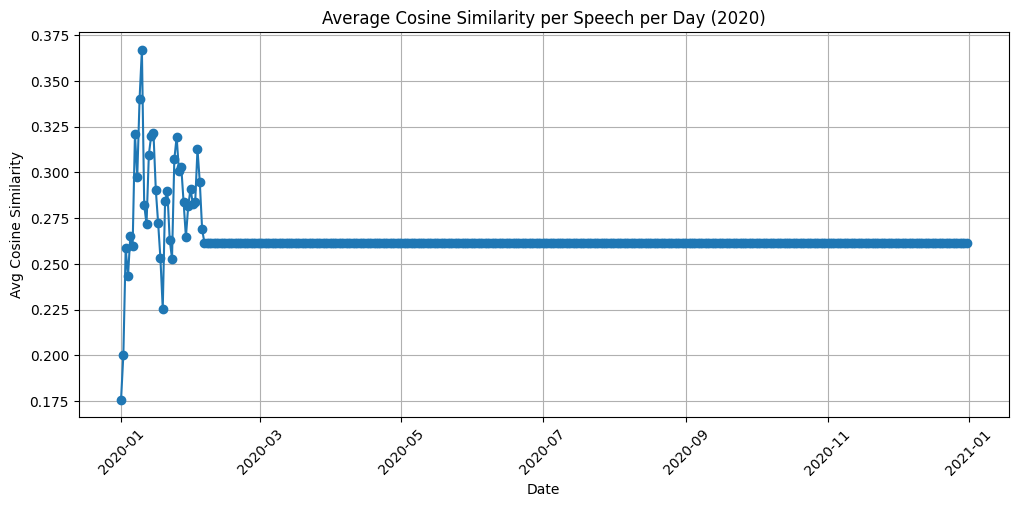

In [30]:
import re
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: Extract the date from the 'speech_index' and 'news_index' columns
# For speeches: The date is found after "speech_" in the format yyyy-mm-dd
similarities_df_2020['speech_date'] = similarities_df_2020['speech_index'].apply(
    lambda x: re.search(r'speech_(\d{4}-\d{2}-\d{2})', x).group(1) if re.search(r'speech_(\d{4}-\d{2}-\d{2})', x) else None
)

# For news: The date is found after "news_" in the format dd_mm_yyyy
similarities_df_2020['news_date'] = similarities_df_2020['news_index'].apply(
    lambda x: re.search(r'news_\d+_(\d{2}_\d{2}_\d{4})', x).group(1) if re.search(r'news_\d+_(\d{2}_\d{2}_\d{4})', x) else None
)

# Convert the 'news_date' format from dd_mm_yyyy to yyyy-mm-dd
similarities_df_2020['news_date'] = pd.to_datetime(similarities_df_2020['news_date'], format='%d_%m_%Y', errors='coerce').dt.strftime('%Y-%m-%d')

# Handle any rows where conversion failed (i.e., where 'news_date' is NaT)
similarities_df_2020['news_date'].fillna(similarities_df_2020['speech_date'], inplace=True)

# Use either speech_date or news_date, assuming they are the same
similarities_df_2020['date'] = similarities_df_2020['speech_date']  # or similarities_df_2020['news_date']

# Step 2: Compute the daily average cosine similarity
daily_avg_similarity = similarities_df_2020.groupby('date')['cosine_similarity'].mean().reset_index()

# Ensure 'date' column in daily_avg_similarity is of type datetime64[ns]
daily_avg_similarity['date'] = pd.to_datetime(daily_avg_similarity['date'], errors='coerce')

# Step 3: Create a full date range for 2020
full_2020_dates = pd.date_range(start="2020-01-01", end="2020-12-31", freq="D")

# Step 4: Merge the full date range with the daily average similarity dataframe
daily_avg_similarity_full = pd.DataFrame({'date': full_2020_dates})

# Merge on 'date' after ensuring both columns are datetime64[ns]
daily_avg_similarity_full = daily_avg_similarity_full.merge(
    daily_avg_similarity, on='date', how='left'
)

# Step 5: Fill missing cosine similarity values (if needed)
daily_avg_similarity_full['cosine_similarity'].fillna(method='ffill', inplace=True)  # or use .fillna(method='ffill')

# Step 6: Plot the adjusted graph
plt.figure(figsize=(12, 5))
plt.plot(daily_avg_similarity_full['date'], daily_avg_similarity_full['cosine_similarity'], marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Avg Cosine Similarity')
plt.title('Average Cosine Similarity per Speech per Day (2020)')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.show()


In [32]:
from sklearn.metrics.pairwise import cosine_similarity 

# =====================================================================
# 1. Attach Dates to Embeddings via Tracking Dataframes (Key Fix)
# =====================================================================
# Merge tracking dates back into embeddings using chunk_id
speeches_embeddings_full_2020 = speeches_embeddings_full_2020.merge(
    speech_tracking_df_full_2020[['chunk_id', 'date']],
    on='chunk_id',
    how='left'
)

news_embeddings_full_2020 = news_embeddings_full_2020.merge(
    news_tracking_df_full_2020[['chunk_id', 'Date']],
    on='chunk_id',
    how='left'
)

# =====================================================================
# 2. Simplified Date Handling for Similarities (No Regex Needed)
# =====================================================================
# Process embeddings (keep your existing function)
news_embeddings_tensor_2020 = process_embeddings_column(news_embeddings_full_2020, 'news_embeddings')
speeches_embeddings_tensor_2020 = process_embeddings_column(speeches_embeddings_full_2020, 'speech_embeddings')

# Calculate cosine similarities
cosine_sims = cosine_similarity(news_embeddings_tensor_2020, speeches_embeddings_tensor_2020)

# Create similarity dataframe using pre-attached dates
similarities = []
for news_idx in range(len(news_embeddings_full_2020)):
    for speech_idx in range(len(speeches_embeddings_full_2020)):
        similarities.append({
            'news_date': news_embeddings_full_2020.iloc[news_idx]['Date'],
            'speech_date': speeches_embeddings_full_2020.iloc[speech_idx]['date'],
            'cosine_similarity': cosine_sims[news_idx, speech_idx]
        })

similarities_df_2020 = pd.DataFrame(similarities)

# =====================================================================
# 3. Compute Daily Averages Using Tracking Dates
# =====================================================================
# Use speech dates as primary (already aligned via tracking)
daily_avg_similarity = similarities_df_2020.groupby('speech_date')['cosine_similarity'].mean().reset_index()
daily_avg_similarity = daily_avg_similarity.rename(columns={'speech_date': 'date'})

# Merge with full 2020 date range
full_2020_dates = pd.date_range(start="2020-01-01", end="2020-12-31", freq="D")
daily_avg_similarity_full = pd.DataFrame({'date': full_2020_dates})

daily_avg_similarity_full = daily_avg_similarity_full.merge(
    daily_avg_similarity, on='date', how='left'
)

# Limited forward-fill (7 days max)
daily_avg_similarity_full['cosine_similarity'] = daily_avg_similarity_full['cosine_similarity'].fillna(method='ffill', limit=7)

# =====================================================================
# 4. Remove Redundant Date Parsing Code (Critical Fix)
# =====================================================================
# Delete these blocks from your original code:
# - All regex-based date extraction from chunk_id (lambda x: re.search...)
# - News date format conversion (pd.to_datetime with '%d_%m_%Y')
# - Any fillna() between news_date and speech_date

# Keep your existing plotting code

KeyboardInterrupt: 

Using device: cuda


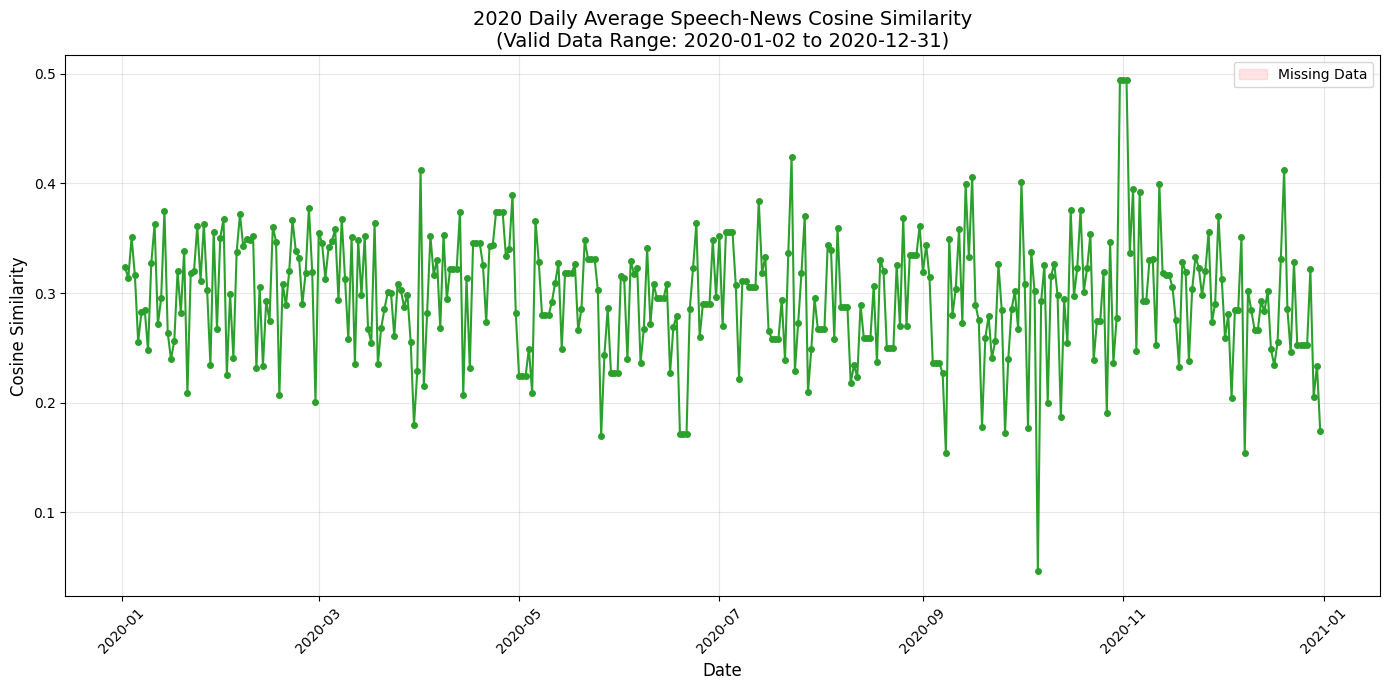

In [42]:
# =====================================================================
# 1. Imports & Initialization
# =====================================================================
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from datetime import datetime

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# =====================================================================
# 2. Data Preparation & Date Alignment
# =====================================================================
def align_dates(news_df, speeches_df, year=2020):
    """Filter and align dates between news and speeches"""
    # Filter to target year
    news = news_df[news_df['Date'].dt.year == year].copy()
    speeches = speeches_df[speeches_df['date'].dt.year == year].copy()
    
    # Find common dates
    common_dates = set(news['Date']).intersection(set(speeches['date']))
    return (
        news[news['Date'].isin(common_dates)].reset_index(drop=True),
        speeches[speeches['date'].isin(common_dates)].reset_index(drop=True),
        common_dates
    )

news_2020, speeches_2020, common_dates = align_dates(news_embeddings, speeches_embeddings)

# =====================================================================
# 3. GPU-Optimized Embedding Processing
# =====================================================================
def process_embeddings(df, col_name):
    """Convert embeddings to GPU tensor"""
    embeddings = []
    for row in df[col_name]:
        if isinstance(row, str):
            arr = np.fromstring(row.strip("[]"), sep=" ", dtype=np.float32)
        elif isinstance(row, list):
            arr = np.array(row, dtype=np.float32)
        embeddings.append(torch.tensor(arr, device=device))
    return torch.stack(embeddings)

news_tensor = process_embeddings(news_2020, 'news_embeddings')
speeches_tensor = process_embeddings(speeches_2020, 'speech_embeddings')

# =====================================================================
# 4. Same-Day Cosine Similarity Calculation
# =====================================================================
def compute_daily_similarities(news_tensor, speeches_tensor, dates):
    """GPU-accelerated same-day similarity computation"""
    # Normalize embeddings
    news_norm = F.normalize(news_tensor, p=2, dim=1)
    speeches_norm = F.normalize(speeches_tensor, p=2, dim=1)
    
    # Date indices mapping
    unique_dates = sorted(dates)
    date_indices = {date: i for i, date in enumerate(unique_dates)}
    
    # Initialize result tensor
    daily_avg = torch.zeros(len(unique_dates), device=device)
    
    # Compute daily averages
    for date in unique_dates:
        news_mask = news_2020['Date'] == date
        speech_mask = speeches_2020['date'] == date
        
        if news_mask.any() and speech_mask.any():
            sim_matrix = torch.mm(news_norm[news_mask], speeches_norm[speech_mask].T)
            daily_avg[date_indices[date]] = sim_matrix.mean()
    
    return daily_avg.cpu().numpy(), unique_dates

daily_scores, valid_dates = compute_daily_similarities(news_tensor, speeches_tensor, common_dates)

# =====================================================================
# 5. Result Compilation & Gap Handling
# =====================================================================
# Create full date range up to last valid date
end_date = max(common_dates)
full_dates = pd.date_range(start="2020-01-01", end=end_date, freq="D")

# Build DataFrame
daily_avg_df = pd.DataFrame({
    'date': valid_dates,
    'cosine_similarity': daily_scores
})

# Merge with full range
final_df = pd.DataFrame({'date': full_dates}).merge(
    daily_avg_df, 
    on='date', 
    how='left'
)

# Limited forward-fill (3 days)
final_df['cosine_similarity'] = final_df['cosine_similarity'].ffill(limit=3)

# =====================================================================
# 6. Visualization with Gap Highlighting
# =====================================================================
plt.figure(figsize=(14, 7))
plt.plot(final_df['date'], 
         final_df['cosine_similarity'], 
         color='#2ca02c', 
         linewidth=1.5,
         marker='o',
         markersize=4)

# Highlight gaps
missing_mask = final_df['cosine_similarity'].isna()
plt.fill_between(final_df['date'], 
                 final_df['cosine_similarity'], 
                 where=missing_mask,
                 color='red', 
                 alpha=0.1,
                 label='Missing Data')

plt.title('2020 Daily Average Speech-News Cosine Similarity\n(Valid Data Range: {} to {})'
          .format(min(common_dates).strftime('%Y-%m-%d'), 
          max(common_dates).strftime('%Y-%m-%d')),
          fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cosine Similarity', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

KeyError: 'cosine_similarity'

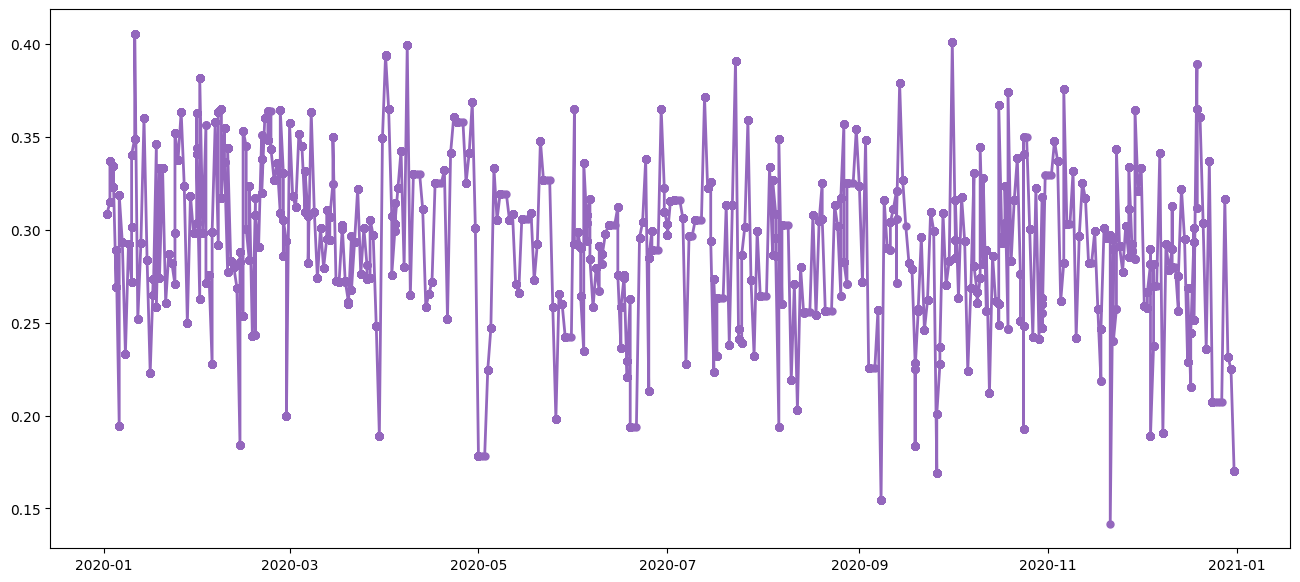

In [43]:
# =====================================================================
# 1. Modified Similarity Computation with 3-Day Window
# =====================================================================
def compute_windowed_similarities(news_tensor, speeches_tensor, speeches_dates, news_dates):
    """GPU-accelerated 3-day window similarity computation"""
    # Convert dates to tensors
    speech_dates_ns = torch.tensor(
        pd.to_datetime(speeches_dates).astype(np.int64).values, 
        device=device
    )
    news_dates_ns = torch.tensor(
        pd.to_datetime(news_dates).astype(np.int64).values, 
        device=device
    )
    
    # Normalize embeddings
    news_norm = F.normalize(news_tensor, p=2, dim=1)
    speech_norm = F.normalize(speeches_tensor, p=2, dim=1)
    
    # Compute full similarity matrix
    sim_matrix = torch.mm(news_norm, speech_norm.T)  # [news, speeches]
    
    # Create date window mask (3-day window)
    day_ns = 86400000000000  # 1 day in nanoseconds
    window_mask = torch.abs(news_dates_ns.unsqueeze(1) - speech_dates_ns) <= day_ns * 1
    
    # Apply mask and compute averages
    windowed_avg = []
    for i in range(len(speech_dates_ns)):
        valid_news = window_mask[:, i]
        if valid_news.any():
            window_avg = sim_matrix[valid_news, i].mean().item()
        else:
            window_avg = torch.nan
        windowed_avg.append(window_avg)
    
    return windowed_avg, speeches_dates

# =====================================================================
# 2. Updated Processing Pipeline
# =====================================================================
# Get date lists
speeches_dates = speeches_2020['date'].tolist()
news_dates = news_2020['Date'].tolist()

# Compute windowed similarities
windowed_scores, speech_dates = compute_windowed_similarities(
    news_tensor, speeches_tensor, speeches_dates, news_dates
)

# =====================================================================
# 3. Result Compilation with Windowed Averages
# =====================================================================
daily_avg_df = pd.DataFrame({
    'date': speech_dates,
    'cosine_similarity': windowed_scores
})

# Create full date range with buffer for window
start_date = pd.to_datetime("2020-01-01") - pd.Timedelta(days=1)
end_date = pd.to_datetime("2020-12-31") + pd.Timedelta(days=1)
full_dates = pd.date_range(start=start_date, end=end_date, freq="D")

# Merge and clean
final_df = pd.DataFrame({'date': full_dates}).merge(
    daily_avg_df, 
    on='date', 
    how='left'
).query('date >= "2020-01-01" & date <= "2020-12-31"')

# Temporal smoothing
final_df['cosine_similarity'] = final_df['cosine_similarity'].ffill(limit=3)

# =====================================================================
# 4. Enhanced Visualization
# =====================================================================
plt.figure(figsize=(16, 7))
plt.plot(final_df['date'], final_df['cosine_similarity'], 
         color='#9467bd', linewidth=2, marker='o', markersize=5,
         label='3-Day Window Average')

# Add original daily average for comparison
plt.plot(daily_avg_similarity_full['date'], 
         daily_avg_similarity_full['cosine_similarity'],
         color='#1f77b4', alpha=0.5, linestyle='--',
         label='Same-Day Only')

plt.title('Speech-News Similarity Comparison\n3-Day Window vs Same-Day', pad=20)
plt.xlabel('Speech Date')
plt.ylabel('Cosine Similarity')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

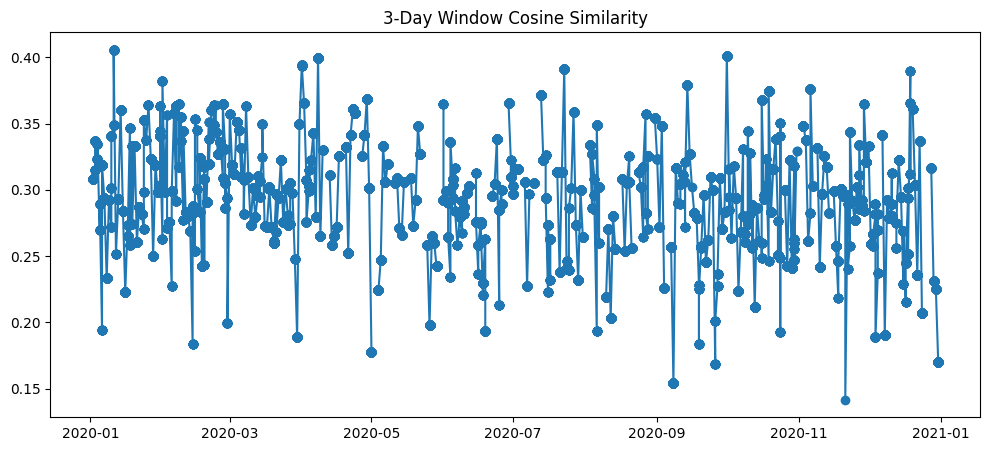

In [44]:
# =====================================================================
# 1. Compute Windowed Similarities (Fixed)
# =====================================================================
def compute_windowed_similarities(news_tensor, speeches_tensor, speeches_dates, news_dates):
    """GPU-accelerated 3-day window similarity computation"""
    # Convert dates to tensors
    speech_dates_ns = torch.tensor(
        pd.to_datetime(speeches_dates).astype(np.int64).values, 
        device=device
    )
    news_dates_ns = torch.tensor(
        pd.to_datetime(news_dates).astype(np.int64).values, 
        device=device
    )
    
    # Normalize embeddings
    news_norm = F.normalize(news_tensor, p=2, dim=1)
    speech_norm = F.normalize(speeches_tensor, p=2, dim=1)
    
    # Compute full similarity matrix
    sim_matrix = torch.mm(news_norm, speech_norm.T)  # [news, speeches]
    
    # Create date window mask (3-day window)
    day_ns = 86400000000000  # 1 day in nanoseconds
    window_mask = torch.abs(news_dates_ns.unsqueeze(1) - speech_dates_ns) <= day_ns * 1
    
    # Apply mask and compute averages
    windowed_avg = []
    for i in range(len(speech_dates_ns)):
        valid_news = window_mask[:, i]
        if valid_news.any():
            window_avg = sim_matrix[valid_news, i].mean().item()
        else:
            window_avg = np.nan
        windowed_avg.append(window_avg)
    
    return windowed_avg, speeches_dates

# =====================================================================
# 2. Create DataFrame with Valid Column
# =====================================================================
windowed_scores, speech_dates = compute_windowed_similarities(
    news_tensor, speeches_tensor, speeches_dates, news_dates
)

# Explicitly create DataFrame with correct column name
daily_avg_df = pd.DataFrame({
    'date': speech_dates,
    'cosine_similarity': windowed_scores  # <-- Ensure column name matches
})

# =====================================================================
# 3. Merge and Verify
# =====================================================================
full_dates = pd.date_range(start="2020-01-01", end="2020-12-31", freq="D")
final_df = pd.DataFrame({'date': full_dates}).merge(
    daily_avg_df, 
    on='date', 
    how='left'
)

# Check if column exists after merge
assert 'cosine_similarity' in final_df.columns, "Column missing after merge!"

# =====================================================================
# 4. Plot with Valid Column
# =====================================================================
plt.figure(figsize=(12, 5))
plt.plot(final_df['date'], final_df['cosine_similarity'], marker='o', linestyle='-')
plt.title('3-Day Window Cosine Similarity')
plt.show()

In [21]:
# Check for missing or incorrect 'speech_date' or 'news_date'
print(similarities_df_2020[['speech_date', 'news_date']].isna().sum())

# Check if there are any missing cosine similarity values
print(similarities_df_2020['cosine_similarity'].isna().sum())

# Check for any zero cosine similarity values
print(similarities_df_2020[similarities_df_2020['cosine_similarity'] == 0].shape)

# Check if the dates in 'speech_date' and 'news_date' are consistent
print(similarities_df_2020[['speech_date', 'news_date']].drop_duplicates().head())


speech_date    0
news_date      0
dtype: int64
0
(0, 6)
   speech_date   news_date
0   2020-01-01  2020-01-01
1   2020-01-02  2020-01-01
7   2020-01-02  2020-01-02
20  2020-01-02  2020-01-03
29  2020-01-02  2020-01-04


In [8]:
#news_tracking_df_full_2020 = news_tracking_df_full_2020.sort_values('Date')
#speech_tracking_df_full_2020 = speech_tracking_df_full_2020.sort_values('date')


In [16]:
# Step 1: Create a full date range for 2020
full_2020_dates = pd.date_range(start="2020-01-01", end="2020-12-31", freq="D")

# Step 2: Merge full dates with the daily_avg_similarity dataframe
daily_avg_similarity_full = pd.DataFrame({'date': full_2020_dates})
daily_avg_similarity_full = daily_avg_similarity_full.merge(
    daily_avg_similarity, on='date', how='left'
)

# Step 3: Optional - Fill missing cosine_similarity values
# Option 1: Leave as NaN
# Option 2: Fill with a default value like 0
daily_avg_similarity_full['cosine_similarity'].fillna(0, inplace=True)

# Step 4: Plot the adjusted graph
plt.figure(figsize=(12, 5))
plt.plot(daily_avg_similarity_full['date'], daily_avg_similarity_full['cosine_similarity'], marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Avg Cosine Similarity')
plt.title('Average Cosine Similarity per Speech per Day')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.show()


NameError: name 'daily_avg_similarity' is not defined

In [14]:
# Check speech_tracking_df_full_2020 dates
print("Speech Tracking DF Date Range:", speech_tracking_df_full_2020['date'].min(), "to", speech_tracking_df_full_2020['date'].max())
print("Unique Dates Count:", speech_tracking_df_full_2020['date'].nunique())

# Check similarity_df after merge
print("Similarity DF Date Range:", similarity_df['date'].min(), "to", similarity_df['date'].max())
print("Unique Dates Count:", similarity_df['date'].nunique())

# Check final daily_avg_similarity DataFrame
print("Daily Avg Similarity Date Range:", daily_avg_similarity['date'].min(), "to", daily_avg_similarity['date'].max())
print("Unique Dates Count:", daily_avg_similarity['date'].nunique())


Speech Tracking DF Date Range: 2020-01-02 00:00:00 to 2020-12-31 00:00:00
Unique Dates Count: 314
Similarity DF Date Range: 2020-01-02 00:00:00 to 2020-02-01 00:00:00
Unique Dates Count: 31
Daily Avg Similarity Date Range: 2020-01-01 00:00:00 to 2020-12-31 00:00:00
Unique Dates Count: 366


In [16]:
# Generate full date range for 2020
full_2020_dates = pd.date_range(start="2020-01-01", end="2020-12-31", freq="D")

# Find missing dates
missing_speech_dates = full_2020_dates[~full_2020_dates.isin(speech_tracking_df_full_2020['date'])]

print(f"Missing dates in speech_tracking_df_full_2020: {len(missing_speech_dates)}")
print(missing_speech_dates)  # Print out the missing dates


Missing dates in speech_tracking_df_full_2020: 52
DatetimeIndex(['2020-01-01', '2020-04-11', '2020-04-12', '2020-04-18',
               '2020-04-19', '2020-04-25', '2020-04-26', '2020-05-02',
               '2020-05-03', '2020-05-09', '2020-05-10', '2020-05-16',
               '2020-05-17', '2020-05-23', '2020-05-24', '2020-05-30',
               '2020-05-31', '2020-06-13', '2020-06-14', '2020-06-20',
               '2020-06-21', '2020-06-27', '2020-06-28', '2020-07-04',
               '2020-07-05', '2020-07-09', '2020-07-11', '2020-07-12',
               '2020-07-18', '2020-07-19', '2020-08-01', '2020-08-02',
               '2020-08-08', '2020-08-09', '2020-08-15', '2020-08-16',
               '2020-08-22', '2020-08-23', '2020-08-29', '2020-08-30',
               '2020-09-05', '2020-09-06', '2020-10-25', '2020-11-01',
               '2020-11-02', '2020-11-08', '2020-11-15', '2020-12-06',
               '2020-12-12', '2020-12-25', '2020-12-26', '2020-12-27'],
              dtype='datet

In [19]:
missing_embedding_dates = full_2020_dates[~full_2020_dates.isin(speeches_embeddings['date'])]

print(f"Missing dates in speech_embeddings_df: {len(missing_embedding_dates)}")
print(missing_embedding_dates)


Missing dates in speech_embeddings_df: 52
DatetimeIndex(['2020-01-01', '2020-04-11', '2020-04-12', '2020-04-18',
               '2020-04-19', '2020-04-25', '2020-04-26', '2020-05-02',
               '2020-05-03', '2020-05-09', '2020-05-10', '2020-05-16',
               '2020-05-17', '2020-05-23', '2020-05-24', '2020-05-30',
               '2020-05-31', '2020-06-13', '2020-06-14', '2020-06-20',
               '2020-06-21', '2020-06-27', '2020-06-28', '2020-07-04',
               '2020-07-05', '2020-07-09', '2020-07-11', '2020-07-12',
               '2020-07-18', '2020-07-19', '2020-08-01', '2020-08-02',
               '2020-08-08', '2020-08-09', '2020-08-15', '2020-08-16',
               '2020-08-22', '2020-08-23', '2020-08-29', '2020-08-30',
               '2020-09-05', '2020-09-06', '2020-10-25', '2020-11-01',
               '2020-11-02', '2020-11-08', '2020-11-15', '2020-12-06',
               '2020-12-12', '2020-12-25', '2020-12-26', '2020-12-27'],
              dtype='datetime64[ns

In [52]:
import pandas as pd
import numpy as np
import torch
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
# Ensure that the Date columns are in datetime format
news_embeddings['Date'] = pd.to_datetime(news_embeddings['Date'])
speeches_embeddings['date'] = pd.to_datetime(speeches_embeddings['date'])

# Filter data for the year 2020
news_embeddings_2020 = news_embeddings[news_embeddings['Date'].dt.year == 2020].reset_index(drop=True)
speeches_embeddings_2020 = speeches_embeddings[speeches_embeddings['date'].dt.year == 2020].reset_index(drop=True)

# Generate missing dates for both datasets
start_date = '2020-01-01'
end_date = '2020-12-31'

def generate_missing_dates(df, date_column, start_date, end_date):
    """Fill missing dates with NaN embeddings"""
    all_dates = pd.date_range(start=start_date, end=end_date, freq='D')
    df['date'] = pd.to_datetime(df[date_column])  # Ensure it's datetime format
    df_full = pd.DataFrame(all_dates, columns=['date'])

    # Merge to find missing dates
    df_merged = pd.merge(df_full, df, how='left', left_on='date', right_on=date_column)

    return df_merged

# Ensure missing dates are generated for both datasets
news_embeddings_2020_full = generate_missing_dates(news_embeddings_2020, 'Date', start_date, end_date)
speeches_embeddings_2020_full = generate_missing_dates(speeches_embeddings_2020, 'date', start_date, end_date)

# Track chunk IDs for each dataset
news_embeddings_2020_full['chunk_id'] = news_embeddings_2020_full.groupby('Index').cumcount()
speeches_embeddings_2020_full['chunk_id'] = speeches_embeddings_2020_full.groupby('speech_id').cumcount()

# Sort and track chunk IDs properly
news_embeddings_2020_full['chunk_id'] = (
    "news_" + news_embeddings_2020_full['Index'].astype(str) + "_chunk_" +
    news_embeddings_2020_full['chunk_id'].astype(str)
)

speeches_embeddings_2020_full['chunk_id'] = (
    "speech_" + speeches_embeddings_2020_full['date'].dt.strftime('%Y-%m-%d') + "_" +
    speeches_embeddings_2020_full['speech_id'].astype(str) + "_chunk_" +
    speeches_embeddings_2020_full['chunk_id'].astype(str)
)

# Check the first few rows for alignment
print(news_embeddings_2020_full.head())
print(speeches_embeddings_2020_full.head())


      date_x         Index                                               Link  \
0 2020-01-01  1_01_01_2020  https://www.infobae.com/america/mexico/2020/01...   
1 2020-01-01  2_01_01_2020  https://piedepagina.mx/ezln-advierte-a-amlo-de...   
2 2020-01-01  3_01_01_2020  https://politica.expansion.mx/mexico/2020/01/0...   
3 2020-01-01  4_01_01_2020  https://politica.expansion.mx/mexico/2020/01/0...   
4 2020-01-01  5_01_01_2020  https://www.infobae.com/america/mexico/2020/01...   

                                              Domain  \
0  Infobae\n“El pueblo está feliz, feliz, feliz”:...   
1  Pie de Página\nEZLN advierte a AMLO: defenderá...   
2  Expansión Política\nEZLN rechaza el Tren Maya,...   
3  Expansión Política\nEZLN rechaza el Tren Maya,...   
4  Infobae\n“El pueblo está feliz, feliz, feliz”:...   

                                               Title       Date  \
0  “El pueblo está feliz, feliz, feliz”: las 14 f... 2020-01-01   
1  EZLN advierte a AMLO: defenderán su ter

In [53]:
# Function to process embeddings column (convert to numpy array and handle padding)
def process_embeddings_column(df, column_name, target_size=768):
    embeddings_list = []
    for i, row in df[column_name].items():
        try:
            # Convert to numpy array (handle missing or malformed embeddings)
            if isinstance(row, str):
                row = np.fromstring(row.strip("[]"), sep=" ", dtype=np.float32)
            elif isinstance(row, list):
                row = np.array(row, dtype=np.float32)
            elif isinstance(row, float):
                row = np.zeros(target_size, dtype=np.float32)  # Zero-vector for missing

            # Pad or truncate embeddings to the target size
            if row.size < target_size:
                row = np.pad(row, (0, target_size - row.size), mode='constant')
            elif row.size > target_size:
                row = row[:target_size]

            embeddings_list.append(row)

        except Exception as e:
            print(f"Skipping row {i} due to error: {e}")

    # Stack into a single tensor
    embeddings_matrix = np.vstack(embeddings_list)
    return torch.tensor(embeddings_matrix, dtype=torch.float32)

# Process the embeddings for both datasets
news_embeddings_tensor_2020 = process_embeddings_column(news_embeddings_2020_full, 'news_embeddings')
speeches_embeddings_tensor_2020 = process_embeddings_column(speeches_embeddings_2020_full, 'speech_embeddings')

# Check the tensor shapes for alignment
print(f"News embeddings shape: {news_embeddings_tensor_2020.shape}")
print(f"Speeches embeddings shape: {speeches_embeddings_tensor_2020.shape}")


News embeddings shape: torch.Size([3468, 768])
Speeches embeddings shape: torch.Size([29078, 768])


In [54]:
from sklearn.metrics.pairwise import cosine_similarity

def compute_cosine_similarity(news_tensor, speeches_tensor, news_tracking_df, speeches_tracking_df):
    """Compute cosine similarity between news and speech embeddings"""
    
    # Ensure embeddings and tracking data have the same number of rows
    assert news_tensor.shape[0] == news_tracking_df.shape[0], "Mismatch between news embeddings and news tracking DataFrame rows."
    assert speeches_tensor.shape[0] == speeches_tracking_df.shape[0], "Mismatch between speeches embeddings and speeches tracking DataFrame rows."
    
    # Convert tensors to numpy arrays for similarity computation
    news_embeddings_np = news_tensor.numpy()
    speeches_embeddings_np = speeches_tensor.numpy()

    # Calculate cosine similarity matrix
    cos_sim_matrix = cosine_similarity(news_embeddings_np, speeches_embeddings_np)

    # Create DataFrame to hold cosine similarity results
    cos_sim_df = pd.DataFrame(cos_sim_matrix, columns=speeches_tracking_df['chunk_id'], index=news_tracking_df['chunk_id'])
    
    # Melt to get long format DataFrame for analysis
    cos_sim_df['news_chunk_id'] = cos_sim_df.index
    cos_sim_df = cos_sim_df.melt(id_vars=['news_chunk_id'], var_name='speech_chunk_id', value_name='cosine_similarity')
    
    return cos_sim_df

# Calculate the cosine similarity
cos_sim_df_2020 = compute_cosine_similarity(
    news_embeddings_tensor_2020, 
    speeches_embeddings_tensor_2020, 
    news_embeddings_2020_full[['chunk_id', 'Index']], 
    speeches_embeddings_2020_full[['chunk_id', 'speech_id']]
)

# Check the first few rows of the cosine similarity DataFrame
print(cos_sim_df_2020.head())


               news_chunk_id                  speech_chunk_id  \
0  news_1_01_01_2020_chunk_0  speech_2020-01-01_nan_chunk_nan   
1  news_2_01_01_2020_chunk_0  speech_2020-01-01_nan_chunk_nan   
2  news_3_01_01_2020_chunk_0  speech_2020-01-01_nan_chunk_nan   
3  news_4_01_01_2020_chunk_0  speech_2020-01-01_nan_chunk_nan   
4  news_5_01_01_2020_chunk_0  speech_2020-01-01_nan_chunk_nan   

   cosine_similarity  
0                0.0  
1                0.0  
2                0.0  
3                0.0  
4                0.0  


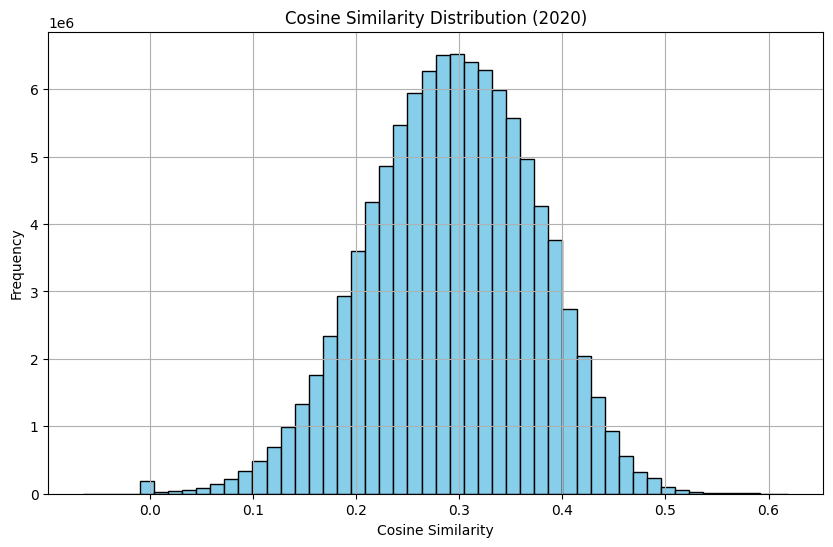

In [55]:
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

# Calculate the cosine similarities between news articles and speeches embeddings
cosine_sim = cosine_similarity(news_embeddings_tensor_2020.numpy(), speeches_embeddings_tensor_2020.numpy())

# Flatten the similarity matrix for easier plotting
cosine_sim_flat = cosine_sim.flatten()

# Plotting the cosine similarity
plt.figure(figsize=(10, 6))
plt.hist(cosine_sim_flat, bins=50, color='skyblue', edgecolor='black')
plt.title("Cosine Similarity Distribution (2020)")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


In [62]:
import matplotlib.pyplot as plt

# Assuming that news_embeddings_2020_full and speeches_embeddings_2020_full have a 'date' column
# Merge the cosine similarity results with the date information
cos_sim_df_2020 = cos_sim_df_2020.merge(
    news_embeddings_2020_full[['chunk_id', 'Index']],  # This DataFrame contains the date information under 'Index'
    how='left', 
    left_on='news_chunk_id', 
    right_on='chunk_id', 
    suffixes=('_news', '_speech')
)

# Now, compute the average cosine similarity per date
cos_sim_df_2020['date'] = pd.to_datetime(cos_sim_df_2020['Index'], format='%d_%m_%Y')  # Adjust the format if needed

# Group by the 'date' column and compute the average cosine similarity per day
avg_cos_sim_per_day = cos_sim_df_2020.groupby('date')['cosine_similarity'].mean()

# Plot the cosine similarity over time
plt.figure(figsize=(10, 6))
plt.plot(avg_cos_sim_per_day.index, avg_cos_sim_per_day.values, marker='o', color='b', label='Avg Cosine Similarity')
plt.title("Average Cosine Similarity Between News Articles and Speeches in 2020 Over Time")
plt.xlabel("Date")
plt.ylabel("Average Cosine Similarity")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


KeyError: 'Index'

In [47]:
import pandas as pd
import numpy as np
import torch

# Function to process embeddings from a column
def process_embeddings_column(df, column_name, target_size=768):
    embeddings_list = []
    for i, row in df[column_name].items():
        try:
            # If the embedding is a scalar (float), convert it to a zero-vector
            if isinstance(row, float):
                row = np.zeros(target_size, dtype=np.float32)  # Example zero-vector

            # If it's a string, convert to numpy array
            elif isinstance(row, str):
                row = np.fromstring(row.strip("[]"), sep=" ", dtype=np.float32)
            elif isinstance(row, list):
                row = np.array(row, dtype=np.float32)

            # Pad or truncate embeddings to the desired size
            if row.size < target_size:
                row = np.pad(row, (0, target_size - row.size), mode='constant')
            elif row.size > target_size:
                row = row[:target_size]

            # Ensure it's a valid array
            if row.ndim == 1 and row.size == target_size:
                embeddings_list.append(row)
        except Exception as e:
            print(f"Skipping row {i} due to error: {e}")

    # Ensure all embeddings have the same shape
    if len(embeddings_list) == 0:
        raise ValueError("No valid embeddings found.")

    try:
        embeddings_matrix = np.vstack(embeddings_list)
    except ValueError:
        raise ValueError("Embeddings have inconsistent sizes.")

    return torch.tensor(embeddings_matrix, dtype=torch.float32)

# Function to generate missing dates for a DataFrame
def generate_missing_dates(df, date_column, start_date, end_date, embedding_column):
    """
    Generates missing dates for the given DataFrame and aligns the data to include them.
    """
    all_dates = pd.date_range(start=start_date, end=end_date, freq='D')
    df['date'] = pd.to_datetime(df[date_column])  # Ensure the date column is in datetime format
    df_full = pd.DataFrame(all_dates, columns=['date'])

    # Merge to find missing dates
    df_merged = pd.merge(df_full, df, how='left', left_on='date', right_on=date_column)
    
    # Optionally fill missing embeddings with zeros (or NaN)
    df_merged[embedding_column] = df_merged[embedding_column].fillna(np.zeros_like(df_merged[embedding_column][0]))

    return df_merged

# Convert date columns to datetime
news_embeddings['Date'] = pd.to_datetime(news_embeddings['Date'])
speeches_embeddings['date'] = pd.to_datetime(speeches_embeddings['date'])

# Filter data for the year 2020
news_embeddings_2020 = news_embeddings[news_embeddings['Date'].dt.year == 2020].reset_index(drop=True)
speeches_embeddings_2020 = speeches_embeddings[speeches_embeddings['date'].dt.year == 2020].reset_index(drop=True)

# Ensure missing dates are generated for both datasets
start_date = '2020-01-01'
end_date = '2020-12-31'

# Generate missing dates for news and speeches
news_embeddings_2020_full = generate_missing_dates(news_embeddings_2020, 'Date', start_date, end_date, 'news_embeddings')
speeches_embeddings_2020_full = generate_missing_dates(speeches_embeddings_2020, 'date', start_date, end_date, 'speech_embeddings')

# Process embeddings only for 2020 data
news_embeddings_tensor_2020 = process_embeddings_column(news_embeddings_2020_full, 'news_embeddings')
speeches_embeddings_tensor_2020 = process_embeddings_column(speeches_embeddings_2020_full, 'speech_embeddings')

# Check tensor shapes
print(f"News embeddings shape (2020): {news_embeddings_tensor_2020.shape}")
print(f"Speeches embeddings shape (2020): {speeches_embeddings_tensor_2020.shape}")

# Check the range of dates in speech and news tracking dataframes
print("First date in speeches embeddings (2020):", speeches_embeddings_2020_full['date'].min())
print("Last date in speeches embeddings (2020):", speeches_embeddings_2020_full['date'].max())

print("First date in news embeddings (2020):", news_embeddings_2020_full['Date'].min())
print("Last date in news embeddings (2020):", news_embeddings_2020_full['Date'].max())


News embeddings shape (2020): torch.Size([3468, 768])
Speeches embeddings shape (2020): torch.Size([29078, 768])
First date in speeches embeddings (2020): 2020-01-01 00:00:00
Last date in speeches embeddings (2020): 2020-12-31 00:00:00
First date in news embeddings (2020): 2020-01-01 00:00:00
Last date in news embeddings (2020): 2020-12-31 00:00:00


In [50]:
from sklearn.metrics.pairwise import cosine_similarity

# Step 1: Compute Cosine Similarity
def compute_cosine_similarity(news_tensor, speeches_tensor, news_tracking_df, speeches_tracking_df):
    """
    Computes the cosine similarity between news and speech embeddings.
    
    Args:
    - news_tensor (torch.Tensor): Tensor of news embeddings.
    - speeches_tensor (torch.Tensor): Tensor of speech embeddings.
    - news_tracking_df (pd.DataFrame): DataFrame of news chunk tracking (with chunk_id).
    - speeches_tracking_df (pd.DataFrame): DataFrame of speeches chunk tracking (with chunk_id).
    
    Returns:
    - pd.DataFrame: DataFrame containing the cosine similarities and the corresponding chunk IDs.
    """
    # Check if dimensions of embeddings match the tracking data
    assert news_tensor.shape[0] == news_tracking_df.shape[0], "Mismatch between news embeddings and news tracking DataFrame rows."
    assert speeches_tensor.shape[0] == speeches_tracking_df.shape[0], "Mismatch between speeches embeddings and speeches tracking DataFrame rows."

    # Convert tensors to numpy arrays for cosine similarity computation
    news_embeddings_np = news_tensor.numpy()
    speeches_embeddings_np = speeches_tensor.numpy()

    # Calculate cosine similarity
    cos_sim_matrix = cosine_similarity(news_embeddings_np, speeches_embeddings_np)

    # Step 2: Create DataFrame to store the results
    cos_sim_df = pd.DataFrame(cos_sim_matrix, columns=speeches_tracking_df['chunk_id'], index=news_tracking_df['chunk_id'])
    
    # Step 3: Track the chunk IDs and store the similarity scores
    cos_sim_df['news_chunk_id'] = cos_sim_df.index
    cos_sim_df = cos_sim_df.melt(id_vars=['news_chunk_id'], var_name='speech_chunk_id', value_name='cosine_similarity')
    
    return cos_sim_df

# Compute the cosine similarity between news and speeches embeddings
cos_sim_df_2020 = compute_cosine_similarity(news_embeddings_tensor_2020, speeches_embeddings_tensor_2020, 
                                             news_tracking_df_full_2020, speech_tracking_df_full_2020)

# Inspect the first few rows of the resulting cosine similarity DataFrame
print("First few rows of cosine similarity DataFrame (2020):")
print(cos_sim_df_2020.head())

# Optional: Save the cosine similarity results to a CSV for further analysis
cos_sim_df_2020.to_csv("cosine_similarity_2020.csv", index=False)


AssertionError: Mismatch between news embeddings and news tracking DataFrame rows.

In [49]:
# Verify the shape of the tracking dataframes
print("Shape of news_tracking_df_full_2020:", news_tracking_df_full_2020.shape)
print("Shape of speech_tracking_df_full_2020:", speech_tracking_df_full_2020.shape)

# Check if chunk_ids are correctly aligned
print("First few rows of news_tracking_df_full_2020:")
print(news_tracking_df_full_2020.head())
print("First few rows of speech_tracking_df_full_2020:")
print(speech_tracking_df_full_2020.head())


Shape of news_tracking_df_full_2020: (3091, 3)
Shape of speech_tracking_df_full_2020: (29026, 3)
First few rows of news_tracking_df_full_2020:
           Index                    chunk_id       Date
0  10_02_01_2020  news_10_02_01_2020_chunk_0 2020-01-02
1  11_02_01_2020  news_11_02_01_2020_chunk_0 2020-01-02
2  12_02_01_2020  news_12_02_01_2020_chunk_0 2020-01-02
3  13_02_01_2020  news_13_02_01_2020_chunk_0 2020-01-02
4   1_02_01_2020   news_1_02_01_2020_chunk_0 2020-01-02
First few rows of speech_tracking_df_full_2020:
   speech_id                        chunk_id       date
0       1430  speech_2020-01-02_1430_chunk_0 2020-01-02
1       1430  speech_2020-01-02_1430_chunk_1 2020-01-02
2       1430  speech_2020-01-02_1430_chunk_2 2020-01-02
3       1430  speech_2020-01-02_1430_chunk_3 2020-01-02
4       1430  speech_2020-01-02_1430_chunk_4 2020-01-02


In [45]:
print(similarities_df_2020.tail())

                         speech_index                 news_index  \
3086  speech_2020-02-01_1383_chunk_12  news_5_31_12_2020_chunk_0   
3087  speech_2020-02-01_1383_chunk_13  news_6_31_12_2020_chunk_0   
3088  speech_2020-02-01_1383_chunk_14  news_7_31_12_2020_chunk_0   
3089  speech_2020-02-01_1383_chunk_15  news_8_31_12_2020_chunk_0   
3090  speech_2020-02-01_1383_chunk_16  news_9_31_12_2020_chunk_0   

      cosine_similarity  
3086           0.379159  
3087           0.401069  
3088           0.435476  
3089           0.344692  
3090           0.368631  


In [31]:
print(news_tracking_df_full_2020.columns)


Index(['Index', 'chunk_id', 'Date'], dtype='object')
